In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Ielādē apmācību un testa datus
df = pd.read_csv('dati_remonts.csv', sep=';')
df_test = pd.read_csv('2024_remonts.csv', sep=';')

In [ ]:
# No apmācības un testa datu kopām atdala kolonnu 'Darījuma summa, EUR'
x_train = df.drop(columns=['Darījuma summa, EUR'])
y_train = df['Darījuma summa, EUR'] 
x_test = df_test.drop(columns=['Darījuma summa, EUR']) 
y_test_actual = df_test['Darījuma summa, EUR'] 

In [4]:
# Definē hiperparametru režģi GridSearchCV funkcijai
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 5, 10, 12],
}

# Izveido lēmumu koka regresijas modeli
dt_reg = DecisionTreeRegressor(random_state=42)

# Ar GridSearchCV veic labāko parametru meklēšanu
grid_search = GridSearchCV(dt_reg, param_grid, scoring='neg_root_mean_squared_error')  
grid_search.fit(x_train, y_train)  # Apmāca modeli ar apmācības datiem

# Iegūst un izdrukā labākos parametrus
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 12, 'min_samples_split': 2}


In [5]:
# Izveido lēmumu koka regresijas modeli, izmantojot labākos atrastos parametrus
best_dt_reg = DecisionTreeRegressor(**best_params, random_state=42)
# Apmāca šo modeli ar apmācību datiem
best_dt_reg.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=12, random_state=42)

In [6]:
# Izmanto apmācīto modeli, lai prognozētu cenas testa datiem
y_test_pred = best_dt_reg.predict(x_test)

In [7]:
# Novērtē modeļa precizitāti uz testa datiem
mae = mean_absolute_error(y_test_actual, y_test_pred)
mse = mean_squared_error(y_test_actual, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_test_pred)

# Aprēķina relatīvās kļūdas
relative_errors = np.abs(y_test_pred - y_test_actual) / y_test_actual
mre = np.max(relative_errors)
are = np.mean(relative_errors)

In [8]:
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")
print(f"MRE: {mre}")
print(f"ARE: {are}")

MAE: 18700.177090292727
MSE: 1007983923.9970003
RMSE: 31748.762558515573
R^2: 0.7953760820856048
MRE: 66.44727737226277
ARE: 0.46386252769489983


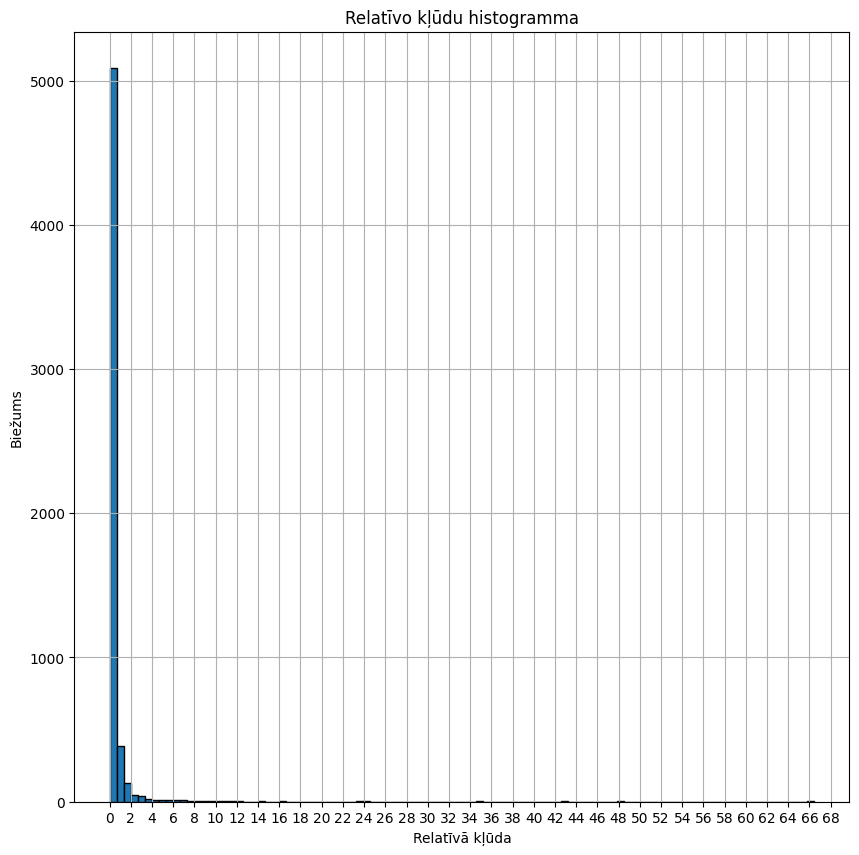

In [ ]:
# Izveido relatīvo kļūdu histogrammu
plt.figure(figsize=(10, 10))
# Histogrammas dati tiek sadalīti 100 intervālos (stabiņos)
plt.hist(relative_errors, bins=100, edgecolor='black')

# Izveido X ass atzīmes no 0 līdz max kļūdai ik pa 2
xticks = np.arange(0, mre + 2, 2)
plt.xticks(xticks)

plt.title('Relatīvo kļūdu histogramma')
plt.xlabel('Relatīvā kļūda')
plt.ylabel('Biežums')
plt.grid(True)
plt.show()

In [10]:
# df_test tiek pievienotas divas jaunas kolonnas
df_test['Prognozētā summa'] = y_test_pred
df_test['Relatīvā kļūda'] = relative_errors

# Sakārtoto datu kopu pēc relatīvās kļūdas, sākot ar lielāko kļūdu
df_test_sort = df_test.sort_values(by='Relatīvā kļūda', ascending=False)

# Izveido jaunu datu kopu, kurā ir tikai trīs kolonnas
kludas = df_test_sort[['Darījuma summa, EUR', 'Prognozētā summa', 'Relatīvā kļūda']]

# Saglabā datus CSV failā
kludas.to_csv('dectr_rel_err.csv', sep=';', index=False)